In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns


az.style.use('arviz-darkgrid')

In [2]:
WAFFLE_DATA = 'waffle_divorce.csv'
DATA_FOLDER = '../../data'

In [3]:
df_waf = pd.read_csv(f'{DATA_FOLDER}/{WAFFLE_DATA}')
df_waf.head()

,Unnamed: 0,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage.SE,Divorce,Divorce.SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,1,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,2,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,3,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,4,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,5,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


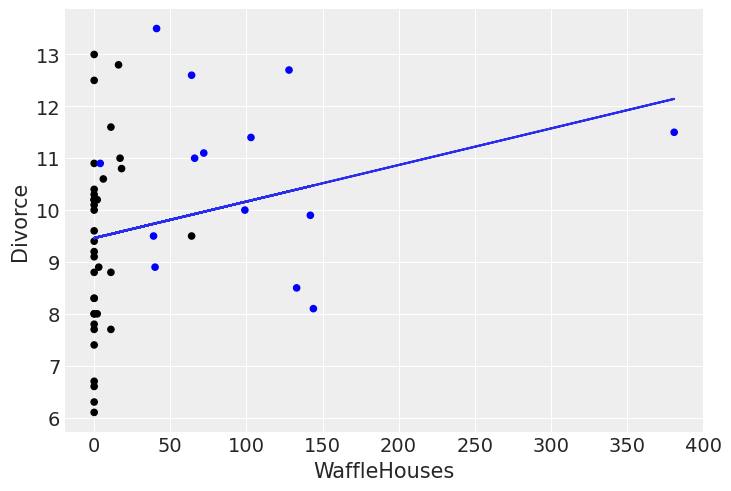

In [4]:
x = df_waf['WaffleHouses']
y = df_waf['Divorce']

colors = df_waf['South'].apply(lambda x: 'b' if x == 1 else 'k')

# Fit the data to a line using polyfit
m, c = np.polyfit(x, y, 1)

# Plot both the line and the original data
_, ax = plt.subplots(1, 1)
ax.plot(x, m * x + c)

df_waf.plot.scatter(x='WaffleHouses', y='Divorce', marker='o', c=colors, ax=ax)

plt.show()

### Code 5.1 Standardize Variables

In [5]:
age = (df_waf['MedianAgeMarriage'] - df_waf['MedianAgeMarriage'].mean()) / df_waf['MedianAgeMarriage'].std()
divorce = (df_waf['Divorce'] - df_waf['Divorce'].mean()) / df_waf['Divorce'].std()
marriage = (df_waf['Marriage'] - df_waf['Marriage'].mean()) /df_waf['Marriage'].std()

## The Model

$$
\begin{align*}
    D_i     & \sim N(\mu_i, \sigma) \\
    \mu_i   & \sim \alpha + \beta_A \cdot A_i \\
    \alpha  & \sim N(0, 0.2) \\
    \beta_A & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

In [6]:
np.std(df_waf['Divorce']), np.std(df_waf['MedianAgeMarriage'])

(1.8025138002245642, 1.231131187160816)

### The Priors

Since both $D_i$ and $A_i$ are standardized, we would expect $\alpha \approx 0$. Thus we may use an even smaller standard deviation value than $0.2$ for the prior of $\alpha$. If $\beta_A = 1$, then a one standard deviation change at the median age of marriage results in a change of one standard deviation in the divorce rate. The prior $\beta_A \sim N(0, 0.5)$ places only $5\%$ probability of that happening.    

### Code 5.3

In [7]:
with pm.Model() as m_5_1:
    alpha = pm.Normal('alpha', mu=0, sigma=0.2)
    beta_A = pm.Normal('beta_A', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', alpha + beta_A * age)
    D = pm.Normal('divorce', mu=mu, sigma=sigma, observed=divorce)
    
    trace_5_1 = pm.sample(5000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_A, alpha]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 17 seconds.


/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta_A'}>,
        <AxesSubplot:title={'center':'beta_A'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

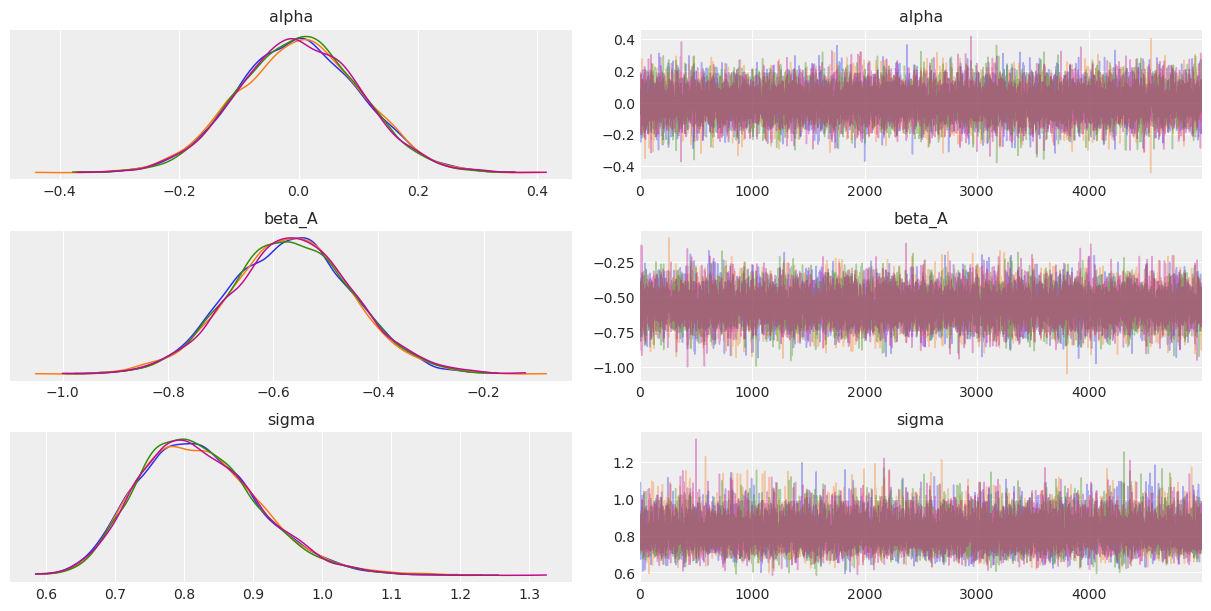

In [8]:
az.plot_trace(trace_5_1, var_names=['alpha', 'beta_A', 'sigma'])

In [9]:
df_trace = pm.trace_to_dataframe(trace_5_1)
df_trace.head()

,alpha,beta_A,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,...,mu__40,mu__41,mu__42,mu__43,mu__44,mu__45,mu__46,mu__47,mu__48,mu__49
0,-0.066763,-0.822454,0.835062,0.431883,0.498016,0.101216,1.093216,-0.560117,0.167349,-1.089184,...,0.233483,0.498016,0.498016,1.754550,-0.626251,-0.295584,0.035083,0.630283,-0.229451,1.159350
1,0.077801,-0.400826,0.901536,0.320818,0.353048,0.159666,0.643121,-0.162637,0.191897,-0.420479,...,0.224127,0.353048,0.353048,0.965423,-0.194867,-0.033715,0.127436,0.417509,-0.001485,0.675351
2,0.010379,-0.459223,0.814288,0.288802,0.325728,0.104171,0.658062,-0.265089,0.141097,-0.560497,...,0.178023,0.325728,0.325728,1.027322,-0.302015,-0.117385,0.067245,0.399580,-0.080459,0.694988
3,-0.026322,-0.724839,0.829902,0.413140,0.471424,0.121719,0.995981,-0.461122,0.180003,-0.927395,...,0.238287,0.471424,0.471424,1.578822,-0.519406,-0.227985,0.063435,0.587992,-0.169701,1.054265
4,0.186497,-0.401875,0.942838,0.430150,0.462465,0.268576,0.753297,-0.054571,0.300891,-0.313088,...,0.333206,0.462465,0.462465,1.076444,-0.086885,0.074688,0.236262,0.527094,0.107003,0.785612


In [10]:
df_mu = df_trace.filter(regex=('mu.*'))
mu_mean = df_mu.apply(np.mean, axis=0)

In [11]:
mu_mean.values.shape

(50,)

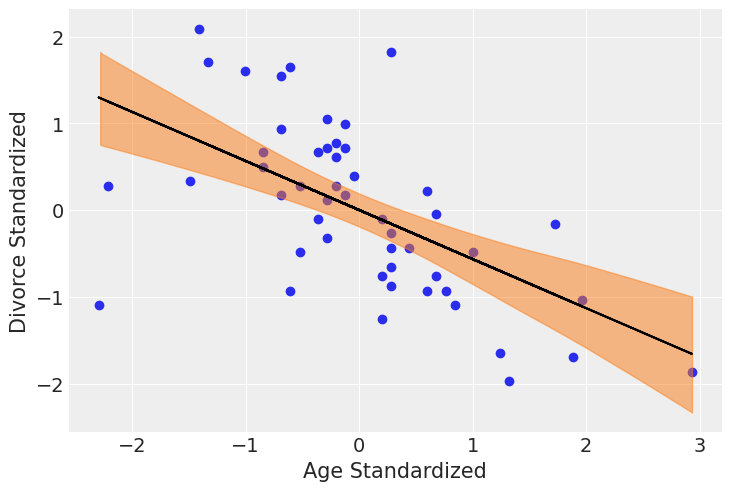

In [12]:
_, ax = plt.subplots(1, 1)
ax.scatter(age, divorce, marker='o')

ax.plot(age, mu_mean, 'k')

az.plot_hdi(age, np.expand_dims(df_mu.values, 0), ax=ax)

ax.set_xlabel('Age Standardized')
ax.set_ylabel('Divorce Standardized')

plt.show()

## Prior Predictive Plots

### Code 5.4

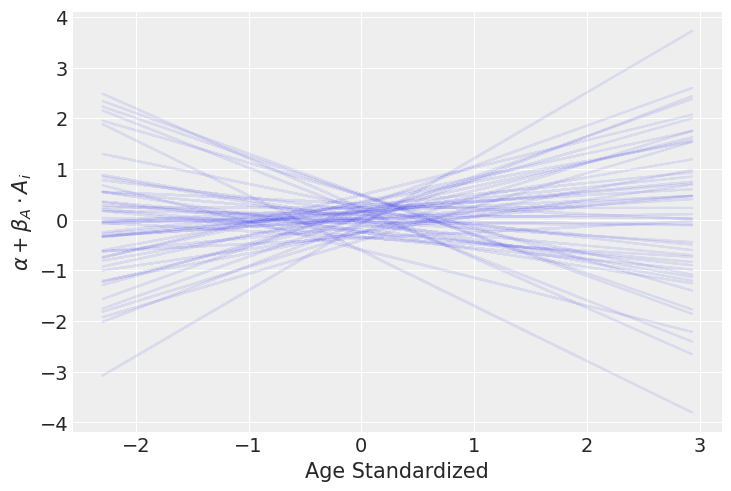

In [13]:
from scipy.stats import norm


N = 50 
alpha_vals = norm.rvs(loc=0, scale=0.2, size=N)
beta_vals = norm.rvs(loc=0, scale=0.5, size=N)

_, ax = plt.subplots(1, 1)
ax.set_xlabel('Age Standardized')
ax.set_ylabel(r'$\alpha + \beta_A \cdot A_i$')

for i in range(N):
    alpha_i = alpha_vals[i]
    beta_i = beta_vals[i]
    
    mu_values = [alpha_i + beta_i * a for a in age]
    
    ax.plot(age, mu_values, color='C0', alpha=0.1)

plt.show()

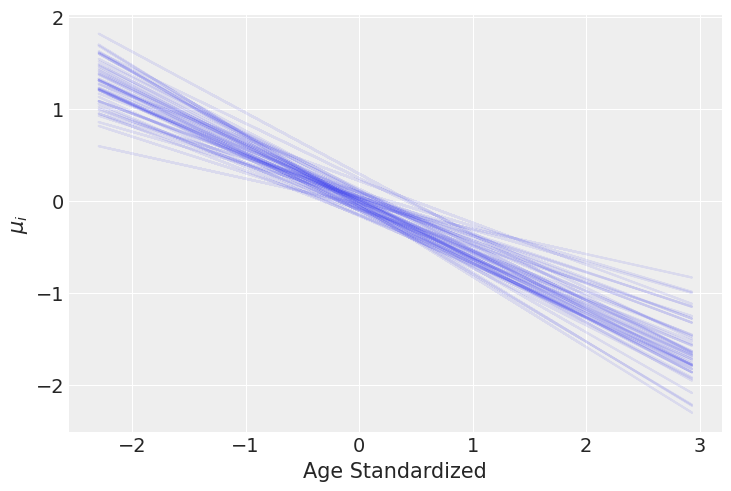

In [14]:
df_mu_T = df_mu.T

sample = np.random.choice(range(0, 20000), size=50)

_, ax = plt.subplots(1, 1)
ax.plot(age, df_mu_T.loc[:, sample], color='C0', alpha=0.1)

ax.set_xlabel('Age Standardized')
ax.set_ylabel(r'$\mu_i$')

plt.show()